# Cell growth on the standard model for a bioreactor (product excluded) in a batch reactor
The goal is to use a simple DGL that displays the characteristic behavior for Substrate consumption and Biomass growth for Data, then train a NN, DMD, or a gaussian Model with it. Afterwards, some values (e.g in the growth rate $\mu(S)$-the Km-value) are in the DGL are changed to generate a new output for the Biomass. Then it is attempted to design an observer, that can make the (now flawed) model converge to the real states.

The system of DGLs that will be used here is :


$$
\begin{aligned}
\dot{b} &= -Db + \rho(s)b \\
\dot{s} &= D(s_e - s) - \rho(s)b
\end{aligned}
$$
with the biomass being the measured output, so that 
$$y(t)=b(t)$$ 

For now, the Dilution rate will be set to 0, as i want to model the batch-reactor first. 
In another file (Cell_growth_easy_model_with_input) i will attempt to also learn the influence of an input to the model!


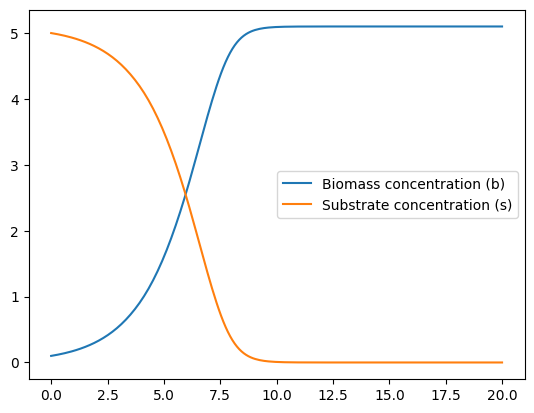

In [115]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import helperfunctions as hf


def Biosystem(t,y, D, K_m, s_e, mu_max):
    b, s = y
    rho = mu_max * s / (K_m + s)
    dbdt = -D * b + rho * b
    dsdt = D * (s_e - s) - rho * b
    return [dbdt, dsdt]


# Initial conditions
y0 = [0.1, 5.0]

# Time span
t_span = (0, 20)
t_eval = np.linspace(*t_span, 200)

# Parameter values
D = 0        # Dilution rate
K_m = 2          # Monod-constant
s_e = 5         # External substrate concentration
mu_max = 0.8       # Maximum specific growth rate

# Solve ODE
sol = solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)

plt.plot(sol.t,sol.y[0], label='Biomass concentration (b)')
plt.plot(sol.t, sol.y[1], label='Substrate concentration (s)')
plt.legend( loc='best')
plt.show()


# <u> **1. Models** </u>

# <u> Neural Network setup and traing Data </u>

In [116]:
#creating and storing more datasets with the same parameters but different initial conditions

Dataset={}
#number of datasets=j
j=10
# better training set:

for i in range (0,j):
    y0=[0.1,1+0.3*i]
    sol_i = solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
    Dataset[f'B{(i)}'] = sol_i.y[0]
    Dataset[f'S{i}'] = sol_i.y[1]



import torch as torch
import torch.nn as nn

#initializing the neural network class that inherits from nn
dim=2                           #b and s
class Neuralnetwork (nn.Module):
    def __init__(self,dim):
        super(Neuralnetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),              
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dim)      
        )
    def forward(self, x):
        return self.model(x)
    
model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function
#weighted function may be good, to value the larger Cells more, since the measurement of these is generally more stable than 
#the measurement of small cells

#stack the datasets together
all_data = []
for i in range(j):
    d = torch.tensor(np.stack([Dataset[f'B{i}'][:], Dataset[f'S{i}'][:]], axis=1), dtype=torch.float32)
    all_data.append(d)
    
    # print(Y_tensor.shape)#199,2

model.load_state_dict(torch.load('./Trained_easy_system_batch/classicNN_(2x128_x_128x128_x_128x2)_20000epochs_batch.pth'))


"""commenting out the Training loop since i already have the model trained and saved"""
# for epoch in range(10000):  # training for n epochs with every dataset included right from the start !
#     optimizer.zero_grad()
#     loss = 0.0

#     for data in all_data:
#         X_tensor = data[:-1]  # all but the last time step
#         Y_tensor = data[1:]   # all
#         output=model(X_tensor)  # accumulate losses
#         loss += criterion(output,Y_tensor)
        
#     loss.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

'commenting out the Training loop since i already have the model trained and saved'

# Validation of the NN with different initial conditions
 
it can be observed, that there is definitely a mismatch between the real trajectory and the predicted trajectory.
-->Checking whether an Observer can help to get the real states of the system, even with wrong initial guess


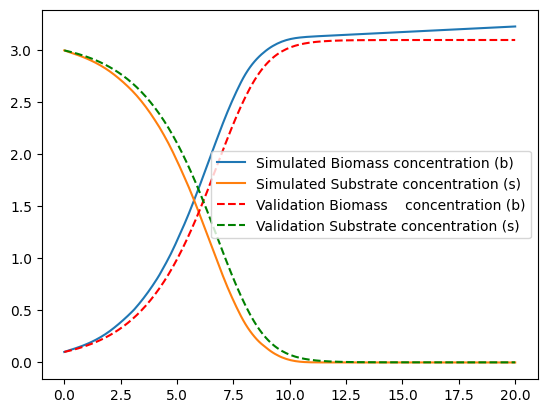

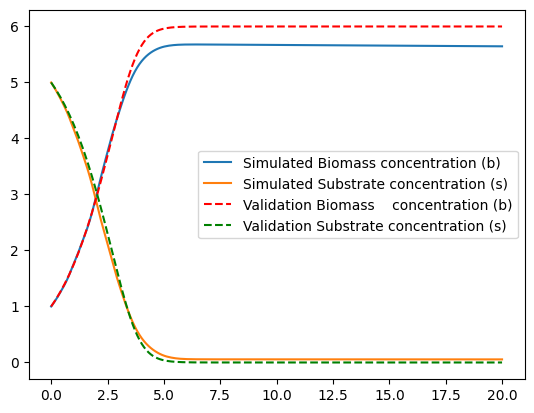

In [117]:
y0=[0.1,3] #initial conditions for the validation with the neural network
y0_2=[1,5]
# K_m=1

model.eval()
validation=solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
validation_2=solve_ivp(Biosystem, t_span, y0_2, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
Dataset_val = {}
Dataset_val['B1'] = validation.y[0]
Dataset_val['S1'] = validation.y[1]
Dataset_val['B2'] = validation_2.y[0]
Dataset_val['S2'] = validation_2.y[1]

##NN simulation
sol_sim=[[0.1,3]]
for i in range (0, len(t_eval)-1):
    sol_prev=sol_sim[i]
    ni=model(torch.tensor(sol_prev,dtype=torch.float32)).detach().numpy()
    sol_sim.append(ni)
plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()

sol_sim=[y0_2]
for i in range (0, len(t_eval)-1):
    sol_prev=sol_sim[i]
    ni=model(torch.tensor(sol_prev,dtype=torch.float32)).detach().numpy()
    sol_sim.append(ni)
plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, Dataset_val['B2'], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, Dataset_val['S2'], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()

# <u>NEURAL ODEs</u>


Neural ODEs are a type of deep neural network, where instead of specifying a discrete sequence of hidden layers, the **derivative of the hidden state** (from the hidden layers) is parameterized using a neural network. Using a differential equation solver, we obtain the output.

One great advantage is the ability to model **continuous-time data**, since we approximate a continuous function rather than perform a discrete forward shift.

##  Hidden State Dynamics

Denoting the hidden state as $h(t)$,  the goal is to approximate:
$$
\frac{dh(t)}{dt} = f(h(t), t, \theta)
$$
The actual states $h(t)$ can then be computed using an ODE solver.



##  Backpropagation and Adjoint Sensitivity

Backpropagation through an ODE solver can lead to:
- High memory cost (storing full trajectories)
- Numerical instability due to solver approximations

To address this, the authors of [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) introduced the **adjoint sensitivity method** (related to Pontryagin's Maximum Principle). The key idea is to **solve a second, augmented ODE *backward in time***.


However i want to stress that normal backpropagation does also work perfectly fine, it is just higher in memory cost.

---
## Loss Function

We define the loss function as:
$$
L(z(t_1)) = L\left(z(t_0) + \int_{t_0}^{t_1} f(z(t), t, \theta) \, dt\right) = L\left(\text{ODESolve}(z(t_0), f, t_0, t_1, \theta)\right)
$$

This yields the optimization problem:
$$
\arg\min_{\theta} L(z(t_1))
$$

As mentioned above, solving directly for the weights results in too much computational load and can introduce errors. So we introduce the following **constraint** based on the system dynamics:
$$
F\left(\dot{z}(t), z(t), \theta, t\right) = \dot{z}(t) - f(z(t), \theta, t) = 0
$$

Here, $\theta$ refers to the weights of the neural network.



## Lagrangian Formulation

Incorporating this constraint into the loss using a Lagrange multiplier $\lambda(t)$, we obtain the Lagrangian:
$$
\psi = L(z(t_1)) - \int_{t_0}^{t_1} \lambda(t) \, F\left(\dot{z}(t), z(t), \theta, t\right) \, dt
$$

Note that the constraint $ F = 0$ doesn't change the solution, because we are optimizing over trajectories that already satisfy:
$$
\dot{z}(t) = f(z(t), \theta, t)
$$

So, with **infinite storage and without numerical instabilities**, direct backpropagation of the loss $ L(z(t_1))$ with respect to $ \theta $ would yield the same result.

In practice, however, backpropagation introduces computational and numerical problems. With this formulation, we can **choose the Lagrange multiplier** in a way that **avoids computing hard derivatives** like:
$$
\frac{dz(t_1)}{d\theta}
$$


##  The Adjoint Equation

After some calculations (explained [here](https://vaipatel.com/posts/deriving-the-adjoint-equation-for-neural-odes-using-lagrange-multipliers/)), we arrive at an ODE for the Lagrange multiplier (also called the **adjoint**):
$$
\frac{d\lambda(t)}{dt} = -\lambda(t)^T \, \frac{\partial f(z(t), t, \theta)}{\partial z}
$$

This is solved **backward in time** from $t_{1}$ to $ t_{0} $.



## Final Gradient Expression

Finally, we obtain the derivative of the loss with respect to the parameters $\theta $:
$$
\frac{dL}{d\theta} = - \int_{t_1}^{t_0} \lambda(t)^T \, \frac{\partial f(z(t), t, \theta)}{\partial \theta} \, dt
$$

Note: the integration goes from $t_{1}$ to $ t_{0}$,  consistent with the backward nature of the adjoint method.


In [118]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np





t = torch.tensor(t_eval, dtype=torch.float32)

#Define ODE function (f from dz/dt = f(z,t))
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.Tanh(),        #TANH instead of ReLU, because it is smooth and continuous, which is better for ODE solvers
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128,dim)
        )

    def forward(self, t, x):
        return self.net(x)

#Setup model and training ---
dim = 2
func = ODEFunc(dim) #<-- ODE function
optimizer = torch.optim.Adam(func.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()


In [119]:

# Combine into [n_timepoints, 2] because dim=2 (B1 and S1)
all_data = []
for i in range(j):
    d = torch.tensor(np.stack([Dataset[f'B{i}'], Dataset[f'S{i}']], axis=1), dtype=torch.float32)
    all_data.append(d)

def myloss_fn(pred, true):
    return torch.mean((pred - true) ** 2)  # Mean squared error for both components
# --- 4. Training loop ---

"""Commenting out the training loop since the model is already trained and saved"""
# for epoch in range(0,4000):
#     optimizer.zero_grad()
#     loss = 0.0

#     for data in all_data:
#         x0 = data[0]
#         x_true = data
#         x_pred = odeint(func, x0, t)
#         loss += myloss_fn(x_pred, x_true)  # accumulate losses

#     loss.backward()
#     optimizer.step()

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# torch.save(func.state_dict(), 'neural_ode_model_2x128x128x128x2_5000epoch_batch.pth')  # Save the model state


'Commenting out the training loop since the model is already trained and saved'

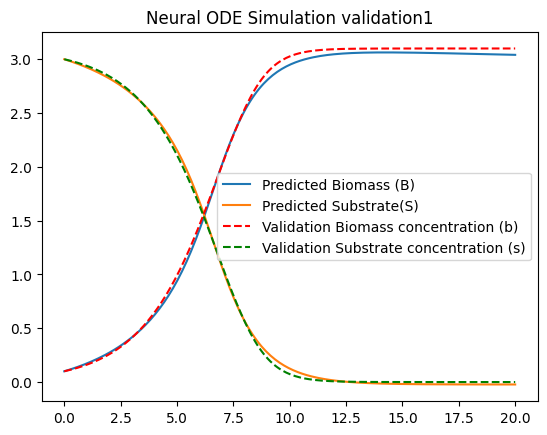

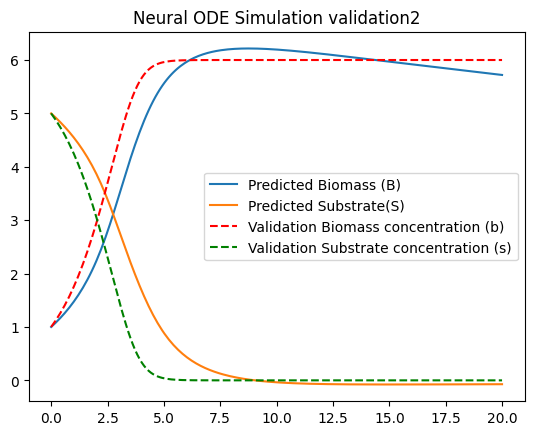

In [120]:
# #simulation
# #load old model
class ODEFunc1(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim,64),
            nn.Tanh(),        #TANH instead of ReLU, because it is smooth and continuous, which is better for ODE solvers,
            nn.Linear(64,dim)
        )

    def forward(self, t, x):
        return self.net(x)
func=ODEFunc1(dim)  # Reinitialize the ODE function
func.load_state_dict(torch.load('./Trained_easy_system_batch/neural_ode_model_2x64x64x2_5000epoch_batch.pth'))
func.eval()
z0_1 = torch.tensor([0.1, 3.0], dtype=torch.float32)  # shape: (2,)
z0_2= torch.tensor([Dataset_val['B2'][0],Dataset_val['S2'][0]], dtype=torch.float32)  # shape: (2,)  # Initial conditions for the validation with the neural network
# Time points (same as t_eval always, but i want to run the boxes seperately)
t = torch.linspace(0, 20, 200)  

# Simulate
z_pred1 = odeint(func, z0_1, t)  
z_pred2 = odeint (func, z0_2, t)  


z_pred1=z_pred1.detach().numpy()
z_pred2=z_pred2.detach().numpy()
#plotting
plt.figure()
plt.title('Neural ODE Simulation validation1')
plt.plot(t.numpy(), z_pred1[:, 0], label='Predicted Biomass (B)')
plt.plot(t.numpy(), z_pred1[:, 1], label='Predicted Substrate(S)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()
# torch.save(func.state_dict(), 'neural_ode_model_2x128x128x128x2_5000epoch_batch.pth')  # Save the model state
# Load the model state
#if you want to load the model after some time without retraining again(as that takes a lot of time)
# func.load_state_dict(torch.load('neural_ode_model_2000epoch.pth'))

plt.figure()
plt.title('Neural ODE Simulation validation2')
plt.plot(t.numpy(), z_pred2[:, 0], label='Predicted Biomass (B)')
plt.plot(t.numpy(), z_pred2[:, 1], label='Predicted Substrate(S)')
plt.plot(t.numpy(), Dataset_val['B2'], 'r--', label='Validation Biomass concentration (b)')
plt.plot(t.numpy(), Dataset_val['S2'], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')
plt.show()

## Very good fit of the Neural ODE here? but only for 1 Dataset
why does the Data fit so badly over the "random initial condition" but better over the other Data, even though it wasnt trained directly on it??
The plot below explains it... 
Because of the way i  initially generated the  initial conditions for the simulations, i didn't sufficiently cover the input space, i basically desribed a diagonal through it.

Just looking at the batch system equations, it is obvious that the trajectory is just following a diagonal line... So obviously different initial conditions along this line may be well described. This is where the issue here lies
in the future this will be changed



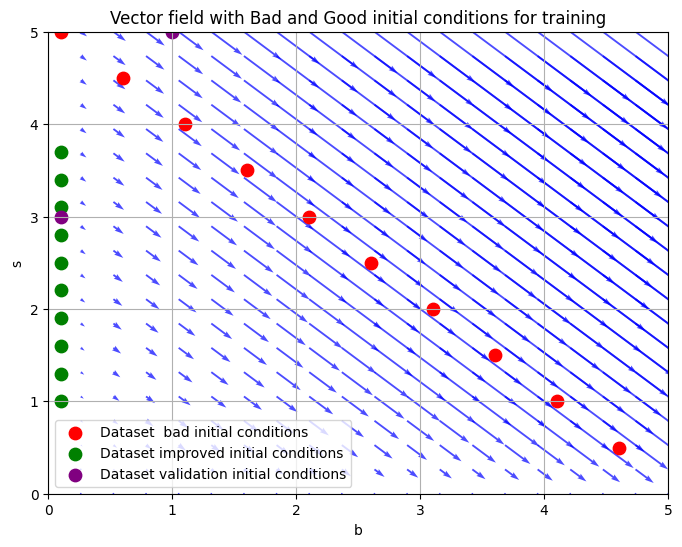

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mumax = 0.8
Km = 2.0

def rho(s):
    return mumax * s / (Km + s)

# Grid for b and s
b = np.linspace(0, 5, 20)
s = np.linspace(0, 5, 20)
B, S = np.meshgrid(b, s)

dB = rho(S) * B
dS = -rho(S) * B

# Dataset initial badly selected points
i_vals = np.arange(10)
b_points = 0.1 + i_vals * 0.5
s_points = 5.0 - i_vals * 0.5

#Dataset better chosen initial points
b_points_good = 0.1 *np.ones(10)
s_points_good = 1 + i_vals * 0.3

b_validation = [Dataset_val['B1'][0], Dataset_val['B2'][0]]
s_validation = [Dataset_val['S1'][0], Dataset_val['S2'][0]]
plt.figure(figsize=(8, 6))
plt.title("Vector field with Bad and Good initial conditions for training")
plt.xlabel('b')
plt.ylabel('s')

# Plot vector field arrows
plt.quiver(B, S, dB, dS, angles='xy', scale_units='xy', scale=3, color='blue', alpha=0.7)

# Plot dataset initial points
plt.scatter(b_points, s_points, color='red', s=80, label='Dataset  bad initial conditions')
plt.scatter(b_points_good,s_points_good,color='green',s=80,label="Dataset improved initial conditions")
plt.scatter(b_validation,s_validation,color='purple',s=80,label="Dataset validation initial conditions")


plt.legend(loc='lower left')
plt.grid(True)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.show()

# <u> DMD and Hankel DMD </u>
Another Data based modeling approach is using the "Dynamic mode Decomposition", where the data is used to find a best fit linear operator for the approximation of the nonlinear system such that
$$x_{k+1}=A\cdot x_{k}$$

The practical computation uses the singular value decomposition of the snapshot matrices  
SVD of $X = U \Sigma V^T$ and $X' = A X = A U \Sigma V^T$

To solve for $A$, use the pseudoinverse:
$$
A = X' V \Sigma^{-1} U^T
$$

Where:
- $X = [x_1, ..., x_{m-1}]$ (data matrix of snapshots)
- $X' = [x_2, ..., x_m]$ (data matrix shifted by one step)
- $U, \Sigma, V^T$ are from the SVD of $X$.

This gives the best-fit linear operator $A$ such that $x_{k+1} \approx A x_k$.

If it were the case that the system dimension was very large, then the Matrix $A (dim=n\times n$) would also be very large, thus increasing the computational load siginificantly. Then, it would be reasonable to use a reduced order System.
In our case however, the system Dimension is 2, thus the matrix A is of dimension $2 \times 2$. So this won't be necessary.

However the low dimensionality might lead to another Problem :

---

### Potential Problems: 

Usually the Data-vector is of high dimension. in our case it only has Dimension 2. This means that $A \in 2\times2$ which might not be sufficient to correctly approximate the Nonlinear Dynamics. If that should be the case, we could also look at so called **Hankel DMD's**
Hankel DMDs split the Datavector and  stack the segments  (each shifted by one time index) on top of each other to increase the dimension of the System. 

---

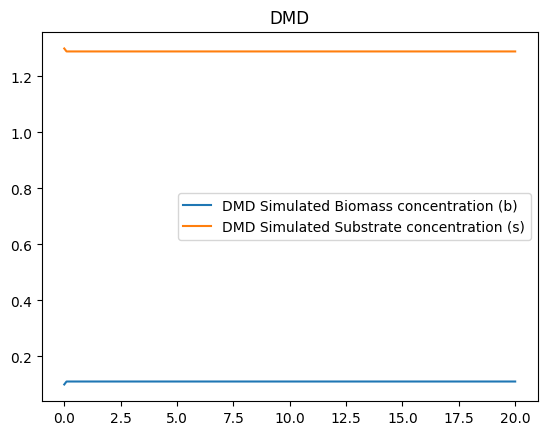

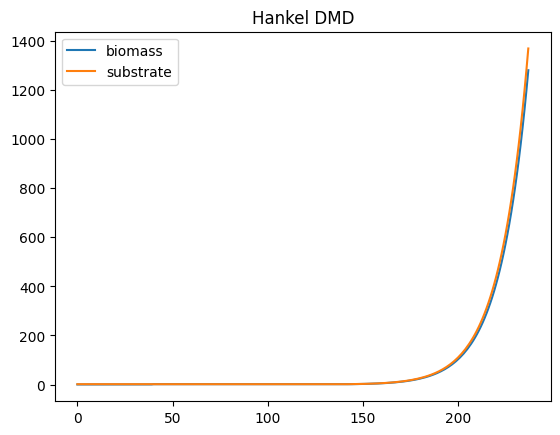

In [122]:
#DMD of the simulated Dataset
X = np.array([Dataset['B1'][:-1], Dataset['S1'][:-1]])
Xp=np.array([Dataset['B1'][1:], Dataset['S1'][1:]])
A,_,_,_ = hf.compute_DMD(X, Xp)
dim=2           #dimension of our system

#now i want to check whether the DMD matrix can predict the next step on the same dataset 
x0 = np.array([Dataset['B1'][0], Dataset['S1'][0]])
for i in range (0, len(t_eval)):
    xi=A@x0
    if i==0:
        sol_dmd=[x0]
    else:
        sol_dmd.append(xi)


# print(np.array(sol_dmd).shape)
plt.plot(t_eval, np.array(sol_dmd)[:, 0], label='DMD Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_dmd)[:, 1], label='DMD Simulated Substrate concentration (s)')
plt.title('DMD')
plt.legend()
plt.show()
#As we can see the system is not really capturing the dynamics of the system, so we can attempt the Hankel DMD
#-------------------------------------Hankel DMD------------------------------------

num_columns=8                                      #number of colums to build DMD with
#i dont stack the full matrix, but only up to the 10th column, because if i use the whole snapshot i would already have all the data i need. 
N_snapshots=40
A_hankel,_,_,_ = hf.compute_hankel_DMD(X[:,:N_snapshots], Xp[:,:N_snapshots], cols=num_columns)

#now i want to check whether the Hankel DMD matrix can predict the next step on the same dataset
x0H=hf. stack_snapshots(X=X[:,:N_snapshots], cols=num_columns)
xkH=x0H
sol_hankel=[hf.unstack_snapshots(xkH,dim)]     #so x0,x1,x2...x9 are in here when starting, and i only append the last entry of the Xp to it 
for i in range (1,199):
    xkH=A_hankel@xkH
    sol_hankel.append(hf.unstack_snapshots(xkH,dim)[-1,:])
    

#sol_hankel currently looks like this :[[dim2xsnapshots],[2x1],[2x1]...]-->into matrix
sol_hankel = np.array([
    np.hstack([mat[0] for mat in sol_hankel]),  # Stack all first rows
    np.hstack([mat[1] for mat in sol_hankel])   # Stack all second rows
])
# print(xkH.shape)
plt.plot(sol_hankel[0,:],label='biomass')
plt.plot(sol_hankel[1,:],label='substrate')
plt.legend(loc='best')
plt.title('Hankel DMD')
plt.show()

i assume the Hankel DMD does not have enough datapoints to accurately display the dynamics. The substrate should not be increasing at all in this constellation. Thus, i assume the DMD is not really suitable for systems of this order. Usually, when applying DMD a huge datavector for each timestep is provided, sometimes up to 1000 values per timestep. Then a DMD is computed and the system order may be reduced to lower computational load, while still capturing the dynamics. In our case however the low system order seems to cause Problems, as even when stacking the values there only is a relatively low amount of values to use for DMD.

# <u> Gaussian Processes </u> 
The best visual and easy to understand explanation i could find was here:

[Gaussian_Process_not_quite_for_dummies](https://thegradient.pub/gaussian-process-not-quite-for-dummies/)


For many ML-Models, providing an input simply offers you the output as a point/vector.  
GPs however provide a **distribution** to reflect **uncertainties** in the prediction.

The basic idea is putting a distribution over the set of all possible **smooth functions** for the dataset, with the assumption that the output of the set of input points follows a **joint Gaussian distribution**:
$$f(x) \sim \mathcal{GP}(m(x), k(x, x'))$$


Where:  
- $m(x) = \mathbb{E}[f(x)]$ is the **mean function** (often assumed to be 0)  
- $k(x, x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))] $ is the **kernel (covariance function)**

---

### Important factors:

- The **Kernel** is a function which measures the **similarity (or correlation)** between two input points.  
  It defines the **covariance structure** of the Gaussian Process and encodes assumptions about the function being modeled, such as periodicity, or linearity.

- Common kernels are **Radial Basis Function (RBF)** and **Linear kernels**. For example, the RBF kernel:

$$k(x, x') = \sigma_f^2 \exp\left( -\frac{(x - x')^2}{2\ell^2} \right)$$

- The choice of kernel has a **significant impact** on the GP's predictions and its ability to capture the underlying data patterns.

- Often, **hyperparameters** (like $ \ell$, $ \sigma_f $) must be tuned to produce the best result.

---

## GP Regression Prediction

Given a joint Gaussian:

$$
\begin{bmatrix}
y_1 \\
y_2
\end{bmatrix}
\sim \mathcal{N}\left(
\begin{bmatrix}
0 \\
0
\end{bmatrix},
\begin{bmatrix}
A & B \\
B^\top & C
\end{bmatrix}
\right)
$$

The conditional distribution of $y_1$ given $y_2$ is:

$$
y_1 \mid y_2 \sim \mathcal{N}(BC^{-1}y_2,\; A - BC^{-1}B^\top)
$$
with $y_1$ being the estimated states and $y_2$ being the points for which there are measurements.

Where the covariance matrices are computed from the kernel function $k(x, x')$ as:

- $A = k(X_1, X_1)$  
- $B = k(X_1, X_2)$  
- $C = k(X_2, X_2) + \sigma^2 I$  (if observations are noisy)

$X_1$ is the set of points in the input space for which the output is to be estimated , and $X_2$ is the set of points in the input space for which there are measurements available.



  

In [123]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# Build training data from multiple datasets
X_list = []
Y_list = []
training_datasets=[]
for i in range(10):  # Assuming you have 10 datasets
    data = {'Biomass': Dataset[f'B{i}'], 'Substrate': Dataset[f'S{i}']}
    training_datasets.append(data)


for data in training_datasets:
    biomass = data['Biomass'].reshape(-1, 1)
    substrate = data['Substrate'].reshape(-1, 1)

    # Input: biomass and substrate at time t
    X_traj = np.hstack([biomass[:-1], substrate[:-1]])
    
    # Output: biomass and substrate at time t+1
    Y_traj = np.hstack([biomass[1:], substrate[1:]])

    X_list.append(X_traj)
    Y_list.append(Y_traj)

# Stack all data from all trajectories
X_train = np.vstack(X_list)
Y_train = np.vstack(Y_list)

# Train the GP model
kernelrbf = GPy.kern.RBF(input_dim=2, active_dims=[0,1], ARD=False)
kernel = kernelrbf
m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)
print(m)


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s11  0010  -3.201323e+04   1.483537e+05 
    11s99  0018  -3.208490e+04   1.046455e-01 
    20s56  0032  -3.208508e+04   8.132493e-06 
    21s78  0034  -3.208508e+04   3.576415e-07 
Runtime:     21s78
Optimization status: Converged


Name : GP regression
Objective : -32085.08330751299
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      1.6530151009863838  |      +ve      |        
  rbf.lengthscale          |      1.6248595936541206  |      +ve      |        
  Gaussian_noise.variance  |  3.2927171142792443e-16  |      +ve      |        


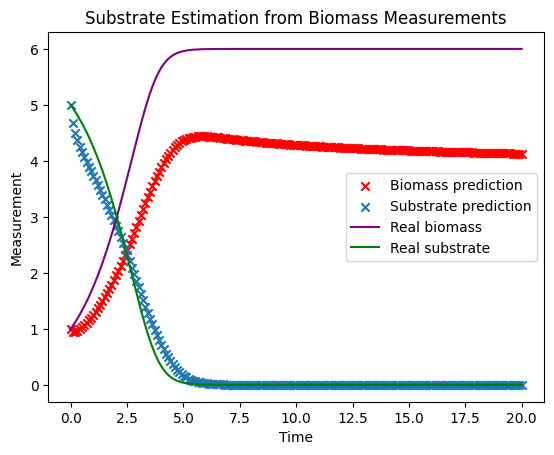

In [124]:

# Prediction with one validation set
n_steps = len(t_eval)
bm = np.zeros(n_steps)
sm = np.zeros(n_steps)


# Initial values from validation set
bm[0] = Dataset_val['B2'][0]
sm[0] = Dataset_val['S2'][0]

for t in range(1, n_steps):
    X_input = np.array([[bm[t-1], sm[t-1]]])
    pred, _ = m.predict(X_input)
    bm[t] = pred[0, 0]
    sm[t] = pred[0, 1]

# Plot predictions
plt.scatter(t_eval, bm, marker='x', color='r', label='Biomass prediction')
plt.scatter(t_eval, sm, marker='x', label='Substrate prediction')
plt.plot(t_eval, Dataset_val['B2'], label='Real biomass', color='purple')
plt.plot(t_eval, Dataset_val['S2'], label='Real substrate', color='green')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Substrate Estimation from Biomass Measurements')
plt.legend()
plt.show()


with time as an additional input it doesnt work as well as the example above. It also doesnt really make sense to include time here, since the data is evenly sampled and the output of the next timestep is not explicitly dependend on process time

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s76  0004  -3.114208e+04   1.047741e+05 
    14s03  0022  -3.148798e+04   1.029587e-01 
    17s67  0028  -3.148799e+04   1.736759e-03 
    18s88  0030  -3.148799e+04   1.453647e-03 
    37s90  0061  -3.148799e+04   1.453647e-03 
Runtime:     37s90
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH


Name : GP regression
Objective : -32085.08330751299
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      1.6530151009863838  |      +ve      |        
  rbf.lengthscale          |      1.6248595936541206  |      +ve      |        
  Gaussian_noise.variance  |  3.2927171142792443e-16  |      +ve      |        


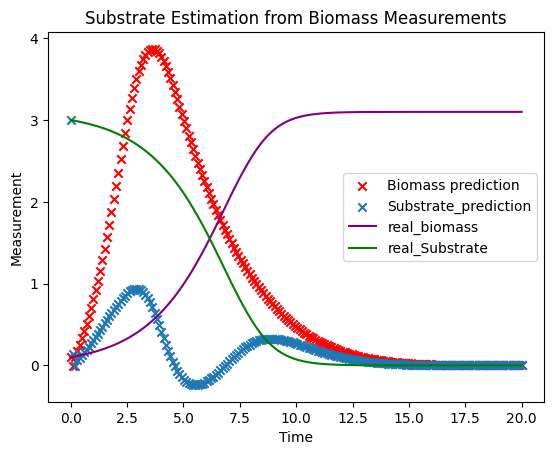

In [125]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# Generate synthetic data (replace with your actual data)
# np.random.seed(42)
time = t_eval.reshape(-1, 1) if t_eval.ndim == 1 else t_eval  # Ensure [n_samples, 1]
# Build training data from multiple datasets
X_list = []
Y_list = []
training_datasets=[]
for i in range(10):  # Assuming you have 10 datasets
    data = {'Biomass': Dataset[f'B{i}'], 'Substrate': Dataset[f'S{i}']}
    training_datasets.append(data)


for data in training_datasets:
    biomass = data['Biomass'].reshape(-1, 1)
    substrate = data['Substrate'].reshape(-1, 1)

    # Input: biomass and substrate at time t
    X_traj = np.hstack([biomass[:-1], substrate[:-1],time[:-1]])
    
    # Output: biomass and substrate at time t+1
    Y_traj = np.hstack([biomass[1:], substrate[1:]])

    X_list.append(X_traj)
    Y_list.append(Y_traj)

    
X_train = np.vstack(X_list)
Y_train = np.vstack(Y_list)

# 1. Train the GP model
kernelrbf = GPy.kern.RBF(input_dim=3, active_dims=[0,1,2], ARD=False)  # ARD for automatic relevance determination-->learns seperate lenght scales (parameter l in RBF equation for smoothness of curve )
# kernelexp =  GPy.kern.Linear(input_dim=2, active_dims=[0,1],ARD=True)

kernel=kernelrbf
m_time = GPy.models.GPRegression(X_train, Y_train, kernel)
m_time.optimize(messages=True)

print(m)  # Show optimized model parameters

# 2. Make predictions with new biomass measurements
# New observations - only biomass known 
n_steps = len(t_eval)
bm = np.zeros(n_steps)
sm = np.zeros(n_steps)

# Initial values

bm[0] = Dataset_val['B1'][0]
sm[0] = Dataset_val['S1'][0]


for t in range(1, n_steps):
    X_input = np.array([[t_eval[t-1],bm[t-1], sm[t-1]]])
    pred, _ = m_time.predict(X_input)
    bm[t] = pred[0, 0]    # predicted biomass-->pred is [[b,s]] so pred[0][0] is b
    sm[t] = pred[0, 1]    # predicted substrate


# Plot substrate predictions
plt.scatter(t_eval, bm, marker='x',color='r', label='Biomass prediction')
plt.scatter(t_eval,sm,marker='x',label='Substrate_prediction')
plt.plot(t_eval,Dataset_val['B1'],label='real_biomass', color='purple')
plt.plot(t_eval,Dataset_val['S1'],label='real_Substrate',color='green')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.title('Substrate Estimation from Biomass Measurements')
plt.legend()
plt.show()

# <u> **Observer** </u>

# <u> Unscented Kalman Filter</u>
In this section it will be attempted to use an Unscented Kalman Filter to account for the wrong initial guess of the Substrate concentration.

The key idea of the UFK is to take sample points around the mean of a gaussian variable and then propagate it through the Neural Network (not the DMD, since the DMD didnt seem to be suited to capture these dynamics), thus using the real model for the dynamics rather than a jacobian. In doing so, the weights attached to the sigma points help to capture the mean and the covariance of the distribution without actual analytical equations of the system dynamics.

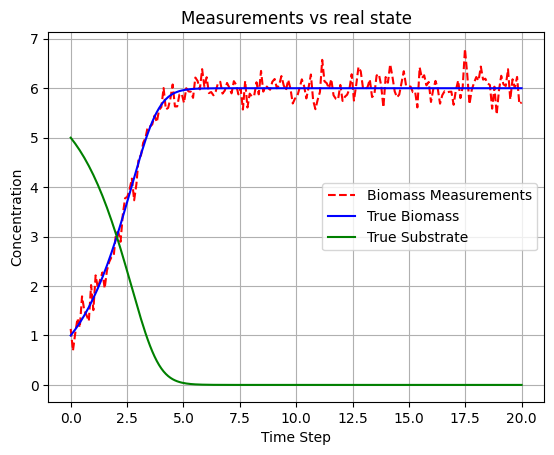

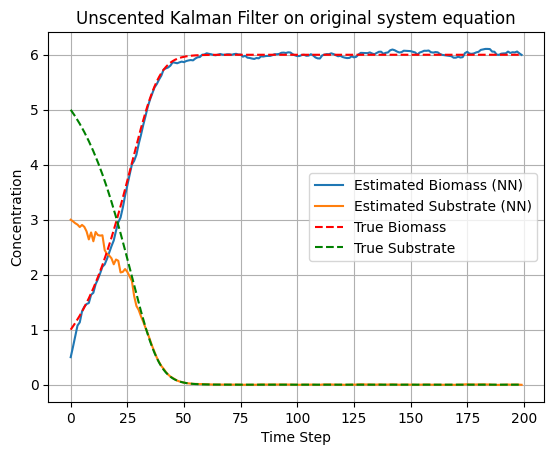

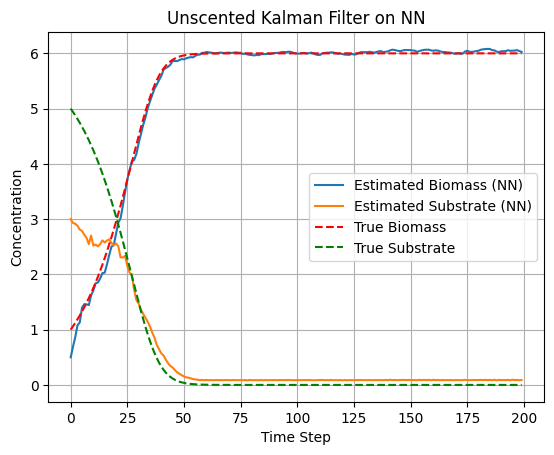

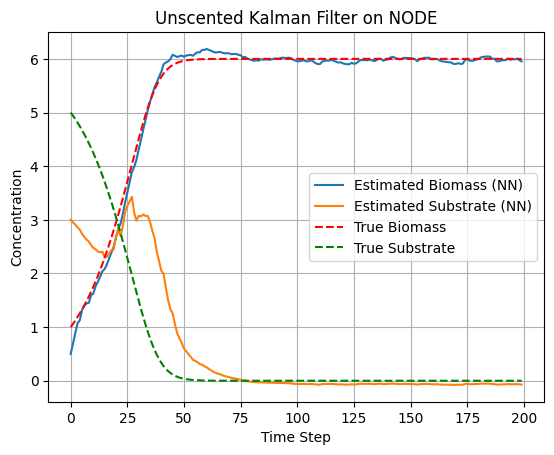

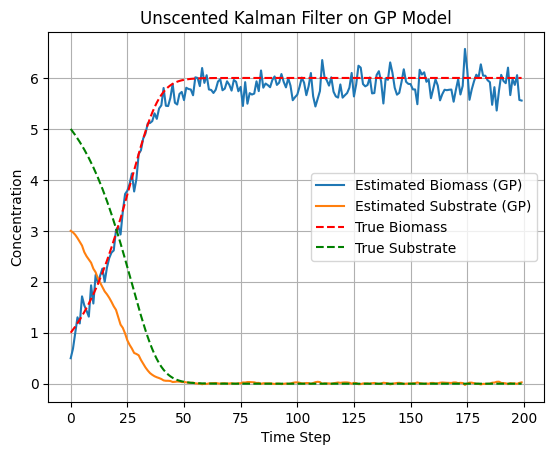

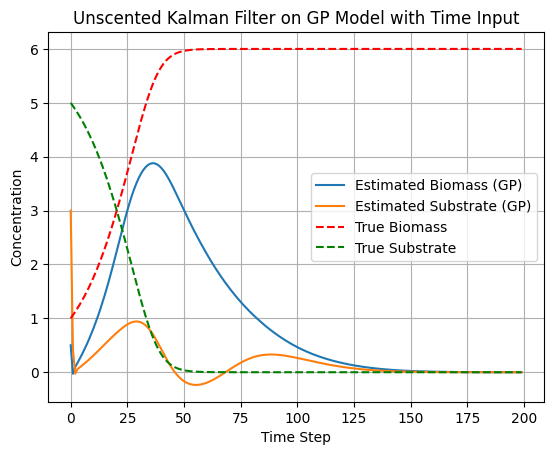

In [129]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import numpy as np
import torch
import matplotlib.pyplot as plt

# simulation time is t_eval (which was about 50 seconds i think)
time_index = 0  # Initialize global time tracker


def original_system(x, dt,**kwargs):
    """State transition function for the original system. f(x(t)) = x(t+1)"""
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    b, s = x
    sol = solve_ivp(Biosystem, (0, dt), [b, s], args=(D, K_m, s_e, mu_max), t_eval=[dt])
    return np.array([sol.y[0][0], sol.y[1][0]])  # Return the state at the next time step
def f_NN(x, dt,**kwargs):
    """State transition function using the neural network. f(x(t)) = x(t+1)"""
    if  not isinstance(x,torch.Tensor):
        x_tensor = torch.tensor(x, dtype=torch.float32)
    else: x_tensor=x
    return model(x_tensor).detach().numpy()

def Neural_ode(x,dt,**kwargs):
    """the Neural ode function needs to be solved with the odeint function. The idea is to solve up to the time where the next measurement
    is available use UKF, and then use the predicted value as the next state"""
    if not isinstance(x,torch.Tensor):
        z0 = torch.tensor(x, dtype=torch.float32)
    else : z0=x
    t = torch.linspace(0,dt,2)  # integrate 1 timestep to tbe next measurement
    z_pred = odeint(func, z0, t,method='dopri5', atol=1e-6, rtol=1e-6)
    z_next = z_pred[-1].detach().numpy()  # take the result at t=dt
    return z_next

#output function
def h(x):
    """Measurement function, in this case only the biomass concentration is measured."""
    return np.array([x[0]])
#Gaussian Process
def GP(x, dt,**kwargs):
    """State transition function using GP with time not being  part of the input."""

    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()  
    b,s=x
    X_input = np.array([[b, s]])
    pred, _ = m.predict(X_input)
    return pred.flatten()  # advance time, use GP to predict [b, s]

def GP_timeinput(x, dt):
    """Gassian Process with time being part of the input"""
    global time_index
    b,s=x
    input_gp = np.array([[t_eval[time_index], b, s]])
    pred, _ = m_time.predict(input_gp)
    
    return np.array([pred[0]])  # advance time, use GP to predict [b, s]

# State dimension: 2 (b, s)
# Measurement dimension: 1 (b)
dim_x_NN = 2
dim_z = 1
dim_x_GP = 2    # State dimension for GP (b, s) without time, as 1 model doesnt include time in the state and 
                # the other doesnt need "measurements" of the time of measurement



# Create sigma points object
"""As suggested in the documentation 
-alpha is the "spread of the sigma points around the mean state, values between 0 and 1 are common
-beta affects the weight of the central sigma point, typically set to 2 for Gaussian distributions
-kappa is a secondary scaling parameter, often set to 0 for simplicity."""
points_NN = MerweScaledSigmaPoints(n=dim_x_NN, alpha=0.1, beta=2.0, kappa=0.0)
points_GP = MerweScaledSigmaPoints(n=dim_x_GP, alpha=0.1, beta=2.0, kappa=0.0)

#-------------------for the NN-----------------------------
# Create UKF object for the NN
ukf_original = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=original_system, hx=h, dt=t_eval[1]-t_eval[0], points=points_NN)
ukf_NN = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=f_NN, hx=h, dt=1.0, points=points_NN)
ukf_NODE = UKF(dim_x=dim_x_NN, dim_z=dim_z, fx=Neural_ode, hx=h, dt=t_eval[1]-t_eval[0], points=points_NN)
ukf_GP = UKF(dim_x=dim_x_GP, dim_z=dim_z, fx=GP, hx=h, dt=1.0, points=points_GP)
ukf_GP_time = UKF(dim_x=dim_x_GP, dim_z=dim_z, fx=GP_timeinput, hx=h, dt=1.0, points=points_GP)

x0=np.array([0.5,3])
# Initial state guess (e.g., wrong s value)
ukf_original.x = x0
ukf_NN.x = x0
ukf_NODE.x = x0
ukf_GP.x = x0
ukf_GP_time.x = x0


# Initial covariance (uncertainty in state)
ukf_original.P = np.eye(dim_x_NN)*3 # Initial covariance matrix for the original system

ukf_NN.P = np.eye(dim_x_NN) * 3 # You can tune this
ukf_NODE.P=np.eye(dim_x_NN) * 3
ukf_GP.P = np.eye(dim_x_GP) * 3  # Adjusted for correct dimension
ukf_GP_time.P = np.eye(dim_x_GP) * 1  # Adjusted for correct dimension


# Process noise (model uncertainty)
ukf_original.Q = np.diag([1e-3, 1e-3]) 
ukf_NN.Q = np.diag([1e-4, 1e-3])         # Tune this based on how inaccurate your NN is
ukf_NODE.Q=np.diag([1e-3, 1e-3])  
ukf_GP.Q = np.diag([1, 1e-1])   
ukf_GP_time.Q = np.diag([1e-3, 1e-3])  

# Measurement noise (e.g., sensor error in b, but i should not have any noise since i simulated with the ODE for the measurement)
ukf_original.R = np.array([0.2])
ukf_NN.R = np.array([[0.2]])  # Measurement noise variance
ukf_NODE.R=  np.array([0.2])
ukf_GP.R = np.array([[0.2]])  # Match NN
ukf_GP_time.R = np.array([[0.2]])  # Match NN


#assume noise measurements
noise = np.random.normal(loc=0.0, scale=0.2, size=Dataset_val['B1'].shape)
b_measurements = Dataset_val['B2'][0:]+noise  # Use the biomass measurements for updating the filter

estimated_states_original = [ukf_original.x.copy()]
estimated_states_NN = [ukf_NN.x.copy()]  # Store the initial state (used for plotting)
estimated_states_NODE = [ukf_NODE.x.copy()]
estimated_states_GP = [ukf_GP.x.copy()]
estimated_states_GP_time = [ukf_GP_time.x.copy()]


time_index=0
for z in b_measurements[1:]:  # Skip the first measurement since i assume the measurement is not available at t=0
    ukf_original.predict()
    ukf_original.update(np.array([z]))
    estimated_states_original.append(ukf_original.x.copy())

    ukf_NN.predict()
    ukf_NN.update(np.array([z]))
    estimated_states_NN.append(ukf_NN.x.copy())

    ukf_NODE.predict()
    ukf_NODE.update(np.array([z]))
    estimated_states_NODE.append(ukf_NODE.x.copy())

    ukf_GP.predict()
    ukf_GP.update(np.array([z]))
    estimated_states_GP.append(ukf_GP.x.copy())

    ukf_GP_time.predict()
    ukf_GP_time.update(np.array([z]))
    estimated_states_GP_time.append(ukf_GP_time.x.copy())
    time_index += 1

#--------------------- Plotting Section ---------------------------

plt.figure()
plt.title('Measurements vs real state')
plt.plot(t_eval, b_measurements, 'r--', label='Biomass Measurements')
plt.plot(t_eval, Dataset_val['B2'], 'b-', label='True Biomass')
plt.plot(t_eval, Dataset_val['S2'], 'g-', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#original equation estimation
estimated_states_original = np.array(estimated_states_original)
plt.figure()
plt.title('Unscented Kalman Filter on original system equation')
plt.plot(estimated_states_original[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_original[:, 1], label='Estimated Substrate (NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#NN results
estimated_states_NN = np.array(estimated_states_NN)
plt.figure()
plt.title('Unscented Kalman Filter on NN')
plt.plot(estimated_states_NN[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_NN[:, 1], label='Estimated Substrate (NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

estimated_states_NODE = np.array(estimated_states_NODE)
plt.figure()
plt.title('Unscented Kalman Filter on NODE')
plt.plot(estimated_states_NODE[:, 0], label='Estimated Biomass (NN)')
plt.plot(estimated_states_NODE[:, 1], label='Estimated Substrate (NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

#GP-based UKF results
estimated_states_GP = np.array(estimated_states_GP)
plt.figure()
plt.title('Unscented Kalman Filter on GP Model')
plt.plot(estimated_states_GP[:, 0], label='Estimated Biomass (GP)')
plt.plot(estimated_states_GP[:, 1], label='Estimated Substrate (GP)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

estimated_states_GP_time = np.array(estimated_states_GP_time)
plt.figure()
plt.title('Unscented Kalman Filter on GP Model with Time Input')
plt.plot(estimated_states_GP_time[:, 0], label='Estimated Biomass (GP)')
plt.plot(estimated_states_GP_time[:, 1], label='Estimated Substrate (GP)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()




# <u> Extended Kalman Filter </u>
Just as the "Normal Kalman Filter" the Extended Kalman Filter also uses the Ricatti equation to find the optimal Kalman gain, but instead of the linear System Matrix A, we approximate the linear dynamics by calculating the Jacobian of our Nonlinear System.
$$
\begin{align*}
x_k &= f(x_{k-1}, u_{k-1}) + w_{k-1}, \quad w_{k-1} \sim \mathcal{N}(0, Q) \\
z_k &= h(x_k) + v_k, \quad v_k \sim \mathcal{N}(0, R)
\end{align*}
$$
$$

\begin{align*}
\text{State Prediction:} \quad &\hat{x}_{p,k} = f(\hat{x}_{k-1}, u_{k-1}) \\
\text{Jacobian of dynamics:} \quad &F_{k-1} = \left. \frac{\partial f}{\partial x} \right|_{x = \hat{x}_{k-1}, u = u_{k-1}} \\
\text{Covariance Prediction:} \quad &P_{p,k} = F_{k-1} P_{k-1} F_{k-1}^\top + Q
\end{align*}
$$
$$
\begin{align*}
\text{Jacobian of measurement:} \quad &H_k = \left. \frac{\partial h}{\partial x} \right|_{x = \hat{x}_{k}} \\
\text{Kalman Gain:} \quad &K_k = P_{p,k} H_k^\top (H_k P_{p,k} H_k^\top + R)^{-1} \\
\text{State Update:} \quad &\hat{x}_{k} = \hat{x}_{p,k} + K_k (z_k - h(\hat{x}_{p,k})) \\
\text{Covariance Update:} \quad &P_{k} = (I - K_k H_k) P_{p,k}
\end{align*}
$$
where $p$ -index stands for the predicted value 

Evaluation after simulation with the "perfect" system model (the model that was used to generate the data):
The Kalman Filter is not suited to capture the nonlinear dynamics in a proper way

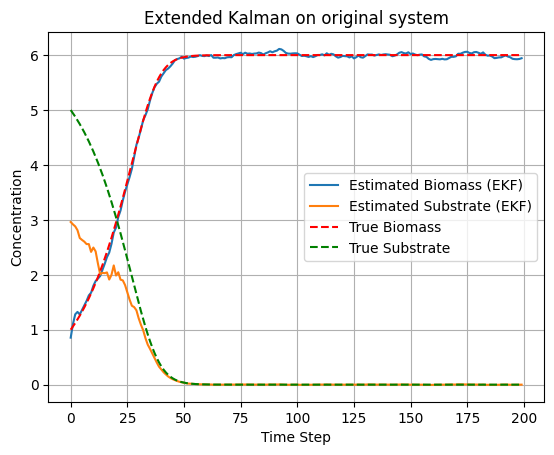

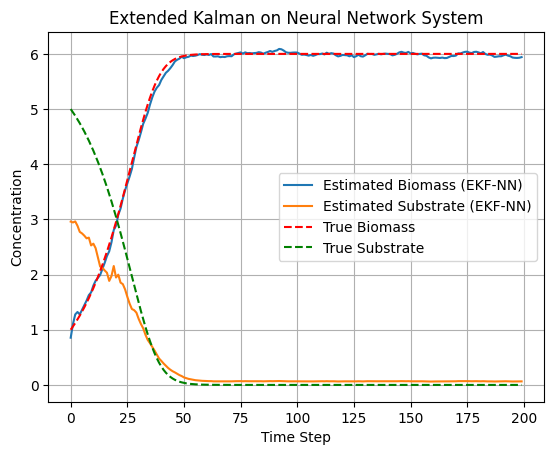

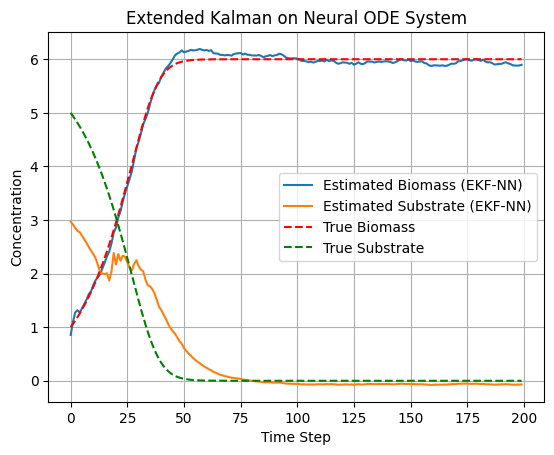

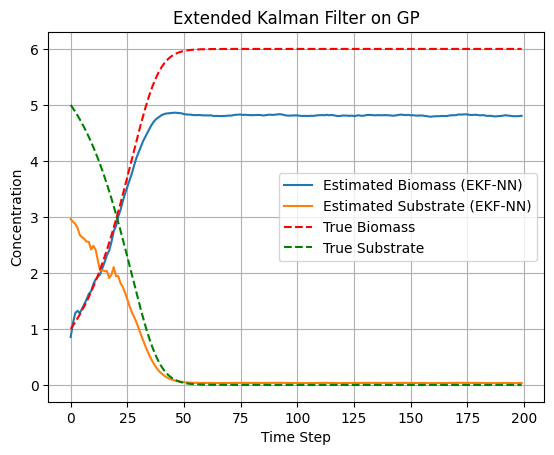

In [127]:
import numpy as np

# def Biosystem(x,dt, D, K_m, s_e, mu_max):
#     b, s = x
#     rho = mu_max * s / (K_m + s)
#     dbdt = -D * b + rho * b
#     dsdt = D * (s_e - s) - rho * b

#     b = b + dbdt * dt
#     s = s + dsdt * dt
#     return np.array([b, s])

def compute_jacobian_analytical(x, dt, D, K_m, s_e, mu_max):
    b, s = x
    rho = mu_max * s / (K_m + s)
    drho_ds = mu_max * K_m / (K_m + s)**2

    df1_db = -D + rho
    df1_ds = b * drho_ds

    df2_db = -rho
    df2_ds = -D - b * drho_ds

    F = np.array([[1 + df1_db * dt, df1_ds * dt],
                  [df2_db * dt, 1 + df2_ds * dt]])
    return F

def compute_jacobian_autograd(x_input,dt=None,**kwargs):
    """ the normal NN gives us x_k+1=f(x_k)"""
    model = kwargs['model']
    x_input=torch.Tensor(x_input)
    x = x_input.clone().detach().requires_grad_(True)
    y = model(x)            #-->give [b,s]

    # dim y is (2,)
    jacobian = []
    for i in range(y.shape[0]):
        grad = torch.autograd.grad(y[i], x, retain_graph=True, create_graph=False)[0] # e.g. dy1/dx1 and dy1/dx2 in the first loop
        jacobian.append(grad.detach().numpy())
    
    return np.stack(jacobian, axis=0)

def compute_jacobian_NODE(x_input, dt=None, **kwargs):

    """we treat f(x) as the model for the conti time dynamics. We calculate the jacobian of it and then use the discretized form of it"""
    #f(x) is used (ideally not the integrated solution), because differntiating through the ODE solver is really computationally expensive 

    model = kwargs['model']  # should be the function f(x) with dx/dt=f(x)
    x_input = torch.tensor(x_input, dtype=torch.float32)
    x = x_input.clone().detach().requires_grad_(True)

    dxdt = model(0,x)  # returns f(x), not the integrated x
    dxdt = dxdt.view(-1)        #flatten in pytorch-->(2,)

    jacobian = []
    for i in range(dxdt.shape[0]):
        grad = torch.autograd.grad(dxdt[i], x, retain_graph=True)[0]
        jacobian.append(grad.detach().numpy())

    J = np.stack(jacobian, axis=0)
    return np.eye(len(x_input)) + J * dt  # 

def compute_jacobian_GP( x, dt, epsilon=1e-5,**kwargs):
    """
    Compute the Jacobian of the GP predictive mean using finite differences.
    Theoretically, this could also be done analytically, since we have the kernel 
    function that is used to calculate the mean of our function, but numerically the 
    following approach works for all types of kernels and models, so it is preferred

   """
    gp_model=kwargs['model']
    x = x.flatten()
    
    def gp_mean(x_input):
        x_input = x_input.reshape(1, -1)
        mu, _ = gp_model.predict(x_input)
        return mu.flatten()

    y0 = gp_mean(x)
    jac = np.zeros((len(y0), len(x)))

    for i in range(len(x)):
        x_eps = x.copy()
        x_eps[i] += epsilon
        y_eps = gp_mean(x_eps)
        jac[:, i] = (y_eps - y0) / epsilon

    return jac
def compute_jacobian_h(x):
    # Measurement is only b, so derivative is [1, 0]
    return np.array([[1, 0]])

def extended_kalman_filter(system_fn,jacobian_f,jacobian_h,y_measurements, x0, P0, Q, R, dt, **kwargs):


    '''
        Parameters:
            system_fn:      Model of the system that takes current state input x_k and yields x_(k+1)
            jacobian_f:     Jacobian of the Model (in discrete time!!!)--> F=I+J*dt where J is the Jacobian of the conti-time system
            jacobian_h:     Jacobian of the ouptut function
            y_measurements: (Noisy) Measurements of the output at discrete times t
            x0:              Estimate of the original state
            P0:              Estimate of initial error Covariance
            Q:               Covariance of Process Noise
            R:               Covariance of Measurement-Noise
            dt:              Time between measurement samples
            **kwargs         All arguments that also need to be passed to the system_fn (like K_m u_max)

        Output:
            x_est: estimate of the state

    
    this function also exists in my helperfunction.py, but i also wanted it in this file for presentation on thursday'''
    n = len(y_measurements)
    x_est = np.zeros((n, 2))
    x = x0.copy()
    x_est[0]=x
    P = P0.copy()

    for k in range(n):
        # === Prediction step ===
        x_pred = system_fn(x, dt,**kwargs)
        F = jacobian_f(x, dt,**kwargs)
        P_pred = F @ P @ F.T + Q

        # === Update step ===
        H = jacobian_h(x_pred)
        dy = y_measurements[k] - H @ x_pred
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        x = x_pred + K @ dy
        P = (np.eye(2) - K @ H) @ P_pred

        x_est[k] = x

    return x_est

dt = t_eval[1]-t_eval[0]  # 20/200
ys = b_measurements # observations of biomass only already added noise to it (in the UKF box)

x0 = np.array([0.5, 3.0])  # Initial state [b, s]
P = np.eye(2) * 3         # Initial covariance
Q = np.diag([1e-3, 1e-3])  # Process noise
R = np.array([[0.2]])     

# model parameters (equal to the real ones used for the DGL)
D = 0
K_m = 2
s_e = 5
mu_max = 0.8

x_estimates = extended_kalman_filter(original_system,compute_jacobian_analytical,compute_jacobian_h,ys, x0, P, Q, R, dt, 
                                     D=D, K_m=K_m, s_e=s_e, mu_max=mu_max)#kwargs 
x_estimates_NN = extended_kalman_filter(f_NN,compute_jacobian_autograd,compute_jacobian_h,ys, x0, P, Q, R, dt,
                                        model=model)
x_estimates_NODE = extended_kalman_filter(Neural_ode,compute_jacobian_NODE,compute_jacobian_h,ys, x0, P, Q, R, dt,
                                        model=func)
x_estimates_GP =extended_kalman_filter(GP,compute_jacobian_GP,compute_jacobian_h,ys, x0, P, Q, R, dt,
                                        model=m)

plt.figure()
plt.title('Extended Kalman on original system')
estimation_results = np.array(x_estimates)
plt.plot(x_estimates[:, 0], label='Estimated Biomass (EKF)')
plt.plot(x_estimates[:, 1], label='Estimated Substrate (EKF)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.title('Extended Kalman on Neural Network System')
x_estimates_NN = np.array(x_estimates_NN)
plt.plot(x_estimates_NN[:, 0], label='Estimated Biomass (EKF-NN)')
plt.plot(x_estimates_NN[:, 1], label='Estimated Substrate (EKF-NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Extended Kalman on Neural ODE System')
x_estimates_NODE = np.array(x_estimates_NODE)
plt.plot(x_estimates_NODE[:, 0], label='Estimated Biomass (EKF-NN)')
plt.plot(x_estimates_NODE[:, 1], label='Estimated Substrate (EKF-NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title("Extended Kalman Filter on GP")
x_estimates_GP=np.array(x_estimates_GP)
plt.plot(x_estimates_GP[:, 0], label='Estimated Biomass (EKF-NN)')
plt.plot(x_estimates_GP[:, 1], label='Estimated Substrate (EKF-NN)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()



# Moving Horizon Estimation (MHE)

Moving Horizon Estimation is an optimization-based state estimation technique that uses a sliding window of past measurements.

## Mathematical Formulation

The MHE optimization problem at time $t_k$ is:

$$
\min_{x_{k-H:k}} \left( \sum_{i=k-H}^{k} \| y_i - C x_i \|^2 + \sum_{i=k-H}^{k-1} \| x_{i+1} - f_\theta(x_i, u_i) \|^2 \right)
$$



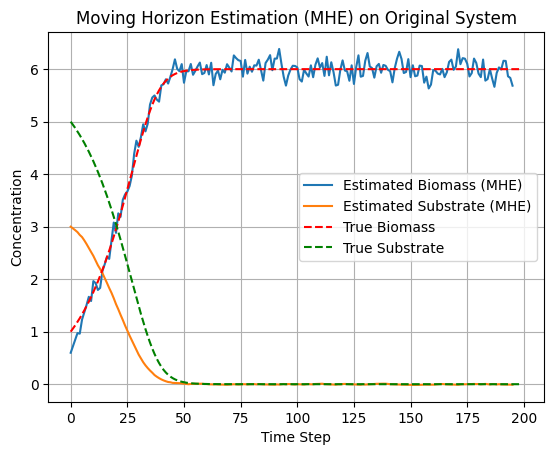

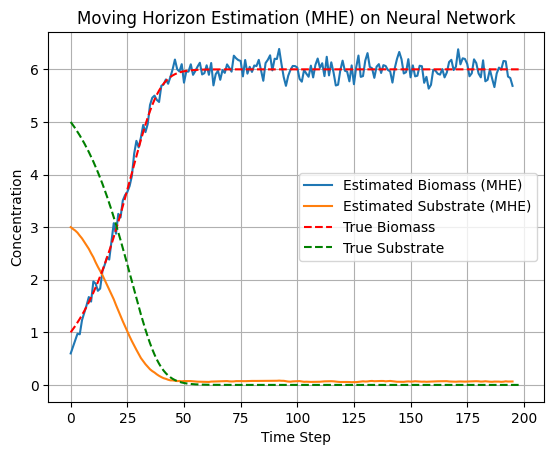

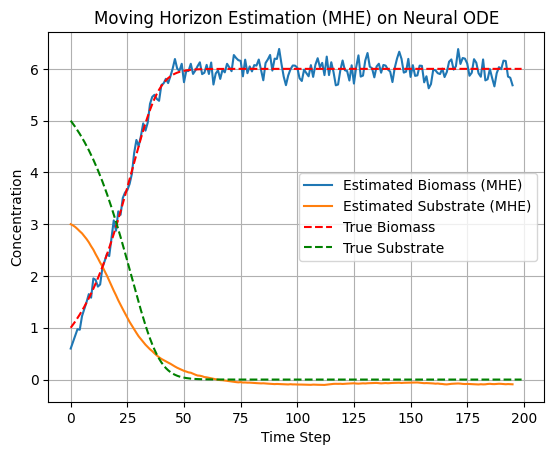

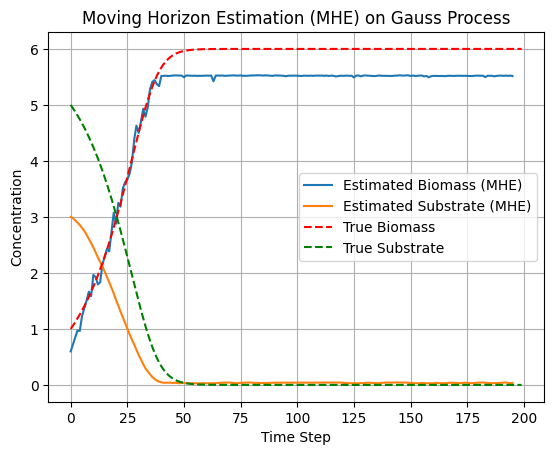

In [128]:
import torch
import torch.optim as optim
import numpy as np

def mhe_estimate(model, y_meas, u_seq=None, window_size=5,
                 x_init_guess=None, num_iter=10, lr=1e-2,
                 Q_diag=None, R_diag=None, P_diag=None,**kwargs):
    
    """ a function to apply the moving horizon estimation to our measurements. 
    Parameters:
        model:          function that makes x_k-->x_k+1 for the  system
        y_meas:         measurements
        u_seq:          input series
        window_size:    nr of measurements used for the moving horizon estimation
        x_init_guess:   initial guess of states (needs to be same size as window size)
        num_iter:       iterations for optimization in each window step
        Q_diag          Process Noise
        R_diag          Measurement Noise
        P_diag          Error Covariance Matrix

    Returns: Estimate of the states up to the last measurement time -window size
    
    
    """

    H = len(y_meas)
    #shifts= how often the sliding window has to iterate to match all the measurements
    nshifts = H - window_size + 1

    # Convert diagonal weights to tensors
    Q_inv = torch.tensor(1.0 / np.array(Q_diag), dtype=torch.float32) if Q_diag is not None else 1.0
    R_inv = torch.tensor(1.0 / np.array(R_diag), dtype=torch.float32) if R_diag is not None else 1.0
    P_inv = torch.tensor(1.0 / np.array(P_diag), dtype=torch.float32) if P_diag is not None else 1.0

    x_est = torch.tensor(x_init_guess, dtype=torch.float32, requires_grad=True)
    estimated_states = []
    prev_estimate = x_est.detach().clone()

    for shift in range(nshifts):
        optimizer = optim.Adam([x_est], lr=lr)

        for _ in range(num_iter):
            optimizer.zero_grad()
            loss = 0.0


            # arrival cost (initial value cost)
            if shift > 0:
                arrival_diff = x_est[0] - prev_estimate[1]
                loss += torch.sum(P_inv * arrival_diff.pow(2))
            

            # measurement cost
            for t in range(window_size):
                y_t = y_meas[shift + t]
                y_pred = x_est[t,0]             #for specific functions this would need modification
                diff = y_t - y_pred
                loss += torch.sum(R_inv * diff.pow(2))
            # model cost
            for t in range(window_size - 1):
                x_t = x_est[t]
                x_pred = model(x_t,**kwargs) if u_seq is None else model(x_t, u_seq[shift + t],**kwargs)

                if isinstance(x_pred, np.ndarray):  #if model returns np. it should be turned into a tensor
                    x_pred = torch.tensor(x_pred, dtype=torch.float32)
    

                diff = x_est[t + 1] - x_pred
                loss += torch.sum(Q_inv * diff.pow(2))

            loss.backward()
            optimizer.step()

        estimated_states.append(x_est[0].detach().clone())
        prev_estimate = x_est.detach().clone()

        with torch.no_grad():
            x_est[:-1] = x_est[1:].clone()
            x_pred = model(x_est[-2], **kwargs)
            if isinstance(x_pred, np.ndarray):
                x_pred = torch.tensor(x_pred, dtype=torch.float32)
            x_est[-1] = x_pred

        # print(shift)
    return torch.stack(estimated_states).numpy()


window_size = 5
x_init_guess_Biosystem = np.array([[0.5, 3.0]])

for i in range(1, window_size):
    x0 = x_init_guess_Biosystem[-1]
    x_next = original_system(x0, dt=t_eval[1] - t_eval[0])
    x_init_guess_Biosystem = np.vstack([x_init_guess_Biosystem, x_next])

x_MHE_original_Biosystem=mhe_estimate(original_system,b_measurements,u_seq=None,window_size=window_size,x_init_guess=x_init_guess_Biosystem,Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])
x_MHE_NN= mhe_estimate(f_NN,b_measurements,u_seq=None,window_size=window_size,x_init_guess=x_init_guess_Biosystem,Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])
x_MHE_NODE = mhe_estimate(Neural_ode,b_measurements,u_seq=None,window_size=window_size,x_init_guess=x_init_guess_Biosystem,Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])
x_MHE_GP   = mhe_estimate(GP,b_measurements,u_seq=None,window_size=window_size,x_init_guess=x_init_guess_Biosystem,Q=Q,R=R,P=P,dt=t_eval[1]-t_eval[0])

plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Original System')
plt.plot(x_MHE_original_Biosystem[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_original_Biosystem[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()


plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Neural Network')
plt.plot(x_MHE_NN[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_NN[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Neural ODE')
plt.plot(x_MHE_NODE[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_NODE[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.title('Moving Horizon Estimation (MHE) on Gauss Process')
plt.plot(x_MHE_GP[:, 0], label='Estimated Biomass (MHE)')
plt.plot(x_MHE_GP[:, 1], label='Estimated Substrate (MHE)')
plt.plot(Dataset_val['B2'], 'r--', label='True Biomass')
plt.plot(Dataset_val['S2'], 'g--', label='True Substrate')
plt.xlabel('Time Step')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()
